In [1]:
%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas
from bisect import bisect
import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [24]:
class Ant(object):
    """
    Ant class, which encapsulates the entire behavior of an ant.
    """
    def __init__(self,model,ant_id):
    
        # Set model link and ID
        self.model = model
        self.ant_id = ant_id
        
    def random_walk(self,s,t):
        #Random Walk
        #initialize
        self.g=self.model.g
        self.last_nodes=[]
        self.last_nodes.append(s)


        #Agent Step
        while self.model.sink not in self.p:
            for self.base_node in self.last_nodes:
                #get neighbors
                self.p_neighbors=self.get_neighbors(self.base_node)
                
                #get pheromone of each edge to neighbor
                self.edge_pheromone_list=[]
                for potential_node in self.p_neighbors:
                    self.edge_pheromone_list.append(self.get_pheromone_edge((base_node,potential_node)))
                
                #get next node
                self.next_node=self.p_neighbors[self.make_decision(self.edge_pheromone_list)]

                #Check termination criteria
                ##2/23/15

        return (self.p)
    
    def get_neighbors(self,node):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_ant_neighbors(node)
    
    def make_decision(self,pheromone_list):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        self.edge_percent_list = [float(i)/sum(pheromone_list) for i in pheromone_list]   
        self.edge_cumulative_percent=numpy.cumsum(self.edge_percent_list)

        #Choose decision index
        self.select_index=bisect(self.edge_cumulative_percent,numpy.random.uniform(0,1,1))
  
        return self.select_index
    
    
    #def get_pheromone_node(self,node):
        """
        Return node pheromone, calling through model.
        """    
    
    
    def get_pheromone_edge(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_edge_pheromone(edge)
    

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

    

In [25]:
class Space(object):
    """
    Space class, which encapsulates the entire behavior of a single "run" ACO.
    """
    def __init__(self, size,num_ants=1,source=(0,0),sink=(3,3)):
        """
        Class constructor.
        """
        # Set our model parameters
        self.size = size
        self.sink = sink
        self.source=source
        self.num_ants=num_ants
        
        # Set our state variables
        self.t = 0
        self.ants = []

        
        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_ants()
        

    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a grid network
        self.g = nx.grid_graph(dim=[self.size,self.size])
        self.g=self.g.to_directed()
        
        #Set Pheromones
        for e in self.g.edges_iter():
            self.g.add_edge(e[0],e[1],capacity=0)
            self.g.add_edge(e[0],e[1],edge_pheromone=1)
            self.g.add_edge(e[0],e[1],capacity_pheromone=[(1,1),(2,1)])
            print(self.g[e[0]][e[1]])

        self.g_layout = nx.spectral_layout(self.g)

        #nx.draw_networkx(self.g, pos=self.g_layout, node_color='#dddddd')
        #print((self.g.number_of_nodes(), self.g.number_of_edges()))

        #plt.show() 
        
    def setup_ants(self):
        """
        Method to setup our space.
        """
        
        # First, begin by creating all ants.
        for i in xrange(self.num_ants):
            self.ants.append(Ant(model=self,ant_id=i))
            
    def get_edge_pheromone(self,edge):
        """
        Get edge decision pheromone for ant call
        """        
        return self.g[edge[0]][edge[1]]['edge_pheromone']
        
        
    def get_ant_neighbors(self,node):
        """
        Get node neighbors for ant call
        """
        return self.g.neighbors(node)
            
    def get_path(self, ant_id):
        """
        Get the path of an ant based on their ID.
        """
        return self.ants[ant_id].random_walk(self.source,self.sink)
    
    def step(self):
        """
        Model step function.
        """
        #Ants make paths
        self.ant_paths=[]
        for i in xrange(self.num_ants):
            self.ant_paths.append((self.get_path(i)))
                                      

{'capacity': 0, 'edge_pheremone': 1, 'capacity_pheremone': [(1, 1), (2, 1)]}
{'capacity': 0, 'edge_pheremone': 1, 'capacity_pheremone': [(1, 1), (2, 1)]}
{'capacity': 0, 'edge_pheremone': 1, 'capacity_pheremone': [(1, 1), (2, 1)]}
{'capacity': 0, 'edge_pheremone': 1, 'capacity_pheremone': [(1, 1), (2, 1)]}
{'capacity': 0, 'edge_pheremone': 1, 'capacity_pheremone': [(1, 1), (2, 1)]}
{'capacity': 0, 'edge_pheremone': 1, 'capacity_pheremone': [(1, 1), (2, 1)]}
{'capacity': 0, 'edge_pheremone': 1, 'capacity_pheremone': [(1, 1), (2, 1)]}
{'capacity': 0, 'edge_pheremone': 1, 'capacity_pheremone': [(1, 1), (2, 1)]}
(4, 8)


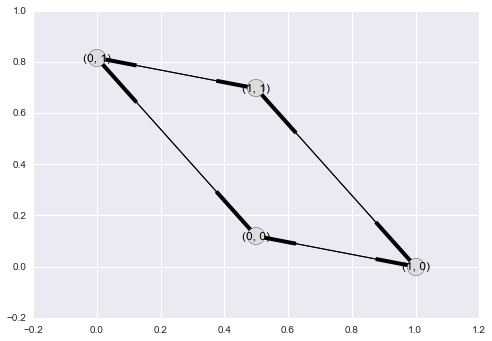

AttributeError: 'Ant' object has no attribute 'p'

In [31]:
space=Space(size=2,num_ants=1)
nx.draw_networkx(space.g, pos=space.g_layout, node_color='#dddddd')
print((space.g.number_of_nodes(), space.g.number_of_edges()))

plt.show()  

space.step()

#print(space.ant_paths)
#print(space.ant_paths[0])
#print(space.ant_paths[1])
p_el=[]
for i in range(0,len(space.ant_paths[0])-1):
    p_el.append((space.ant_paths[0][i],space.ant_paths[0][i+1]))
    

# Remove the infected from healthy nodes
nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_paths[0]]


# Now we can visualize the infected node's position
f = plt.figure()
nx.draw_networkx_nodes(space.g, space.g_layout,
                       nodelist=space.ant_paths[0],
                       node_color='red')

nx.draw_networkx_nodes(space.g, space.g_layout,
                       nodelist=nonpath_nodes,
                       node_color='#dddddd')

nx.draw_networkx_edges(space.g, space.g_layout, 
                       width=1.0, 
                       alpha=0.5,
                       edge_color='#111111')

nx.draw_networkx_edges(space.g, space.g_layout,
                       edgelist=p_el,
                       width=1.0, 
                       alpha=0.5,
                       edge_color='red')


_ = nx.draw_networkx_labels(space.g, space.g_layout,
                        dict(zip(space.g.nodes(), space.g.nodes())),
                        font_size=10)

In [29]:
g = nx.grid_graph(dim=[1,2])

g=g.to_directed()

g.add_edge((0,0),(0,1),capacity=0)
g.add_edge((0,0),(0,1),edge_pheromone=1)
g.add_edge((0,0),(0,1),capacity_pheromone=[(1,1),(2,1)])
print(g.nodes())
print(g.edges())
print(g[(0,0)][(0,1)]['capacity'])
g[(0,0)][(0,1)]



[(0, 1), (0, 0)]
[((0, 1), (0, 0)), ((0, 0), (0, 1))]
0


{'capacity': 0, 'capacity_pheromone': [(1, 1), (2, 1)], 'edge_pheromone': 1}

In [63]:
#Pheromone test

l=[.1,.2,.2]
nl=[0]
for i in xrange(len(l)):
    nl.append(l[i]/sum(l))

print(nl)

[0.2, 0.4, 0.4]


In [32]:
from bisect import bisect
g = nx.grid_graph(dim=[2,2])

g=g.to_directed()

for e in g.edges_iter():
    #print(e)
    g.add_edge(e[0],e[1],capacity=0)
    g.add_edge(e[0],e[1],edge_pheromone=1)
    g.add_edge(e[0],e[1],capacity_pheromone=[(1,1),(2,1)])
    #print(g[e[0]][e[1]])

#print(g.nodes())
node=(0,0)
n_neighbors=g.neighbors(node)
#print(n_neighbors)
epl=[]

#Get pheromone for each neighbor edge
for n in n_neighbors:
    #print(n)
    edge=(node,n)
    #print(edge)
    pheromone=g[edge[0]][edge[1]]['edge_pheromone']
    epl.append((edge,pheromone))
    
print(epl)

#convert pheromone to percentage
epherl=[]
for i in xrange(len(epl)):
    epherl.append(epl[i][1])
print(epherl)
    
epercl = [float(i)/sum(epherl) for i in epherl]   
print(epercl)

ecumsum=numpy.cumsum(epercl)
print(ecumsum)

#select node
#random_select=numpy.random.uniform(0,1,1)
#print(random_select)
index=bisect(ecumsum,numpy.random.uniform(0,1,1))
print(index)
next_node=n_neighbors[index]
print(n_neighbors)
print(next_node)
print(node in g)

[(((0, 0), (0, 1)), 1), (((0, 0), (1, 0)), 1)]
[1, 1]
[0.5, 0.5]
[ 0.5  1. ]
0
[(0, 1), (1, 0)]
(0, 1)
True
